In [90]:
!conda install -c schrodinger pymol

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: | ^C
failed with initial frozen solve. Retrying with flexible solve.

CondaError: KeyboardInterrupt



In [1]:
!pip install goatools

     |████████████████████████████████| 15.8 MB 1.2 MB/s eta 0:00:01
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13724 sha256=8ae82638661b5f6bd08374e32486f1fb0a28ffee8e1ed9f577eeb538db2530a5
  Stored in directory: /Users/whe3/Library/Caches/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt


In [1]:
## Download ontologies from http://geneontology.org/ontology/go-basic.obo
## Download associations from ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz

from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader

obo_fname = download_go_basic_obo()
fin_gene2go = download_ncbi_associations()
obodag = GODag("go-basic.obo")

$ get http://purl.obolibrary.org/obo/go/go-basic.obo
requests.get(http://purl.obolibrary.org/obo/go/go-basic.obo, stream=True)
  WROTE: go-basic.obo

$ get ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz
FTP RETR ftp.ncbi.nlm.nih.gov gene/DATA gene2go.gz -> gene2go.gz
$ gunzip gene2go.gz
go-basic.obo: fmt(1.2) rel(2023-05-10) 46,490 Terms


In [31]:
# Read NCBI's gene2go. Store annotations in a list of namedtuples

objanno = Gene2GoReader(fin_gene2go, taxids=[9606])
ns2assoc = objanno.get_ns2assc()

for nspc, id2gos in ns2assoc.items():
    print("{NS} {N:,} annotated human genes".format(NS=nspc, N=len(id2gos)))

HMS:0:00:03.211627 345,832 annotations, 20,748 genes, 18,938 GOs, 1 taxids READ: gene2go 
MF 18,313 annotated human genes
CC 19,757 annotated human genes
BP 18,686 annotated human genes


In [ ]:
## Download background genes from NCBI

# https://www.ncbi.nlm.nih.gov/gene

# Query NCBI Gene:
# "9606"[Taxonomy ID] AND alive[property] AND genetype protein coding[Properties]
# Click "Send to:"
# Select "File"
# Select "Create File" button The default name of the tsv file is gene_result.txt

In [88]:
## generate protein-coding gene names python module
!mv /Users/whe3/Downloads/gene_result.txt ./
!python /Users/whe3/anaconda3/bin/ncbi_gene_results_to_python.py gene_result.txt -o genes_ncbi_human_proteincoding.py

mv: /Users/whe3/Downloads/gene_result.txt: No such file or directory
      20,661 lines READ:  gene_result.txt
      20,641 geneids WROTE: genes_ncbi_human_proteincoding.py


In [32]:
from genes_ncbi_human_proteincoding import GENEID2NT as GeneID2nt_human

print(len(GeneID2nt_human))

20641


In [33]:
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

goeaobj = GOEnrichmentStudyNS(
        GeneID2nt_human.keys(), # List of human protein-coding genes
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method


Load BP Ontology Enrichment Analysis ...
 82% 17,018 of 20,641 population items found in association

Load CC Ontology Enrichment Analysis ...
 88% 18,105 of 20,641 population items found in association

Load MF Ontology Enrichment Analysis ...
 85% 17,577 of 20,641 population items found in association


In [45]:
## Get all the go items including those appears multiple times

GO_items = []

temp = goeaobj.ns2objgoea['BP'].assoc
for item in temp:
    GO_items += temp[item]
    

temp = goeaobj.ns2objgoea['CC'].assoc
for item in temp:
    GO_items += temp[item]
    

temp = goeaobj.ns2objgoea['MF'].assoc
for item in temp:
    GO_items += temp[item]

In [40]:
## Build mapping dictionaries between gene id and gene symbols

id_mapper = {}

for key in GeneID2nt_human:
    id_mapper[GeneID2nt_human[key].Symbol] = GeneID2nt_human[key].GeneID
    
rev_mapper = {v: k for k, v in id_mapper.items()}  

In [36]:
import numpy as np

def go_analysis(gene_list):
    
    mapped_gene = []

    for gene in gene_list:
        try:
            mapped_gene.append(id_mapper[gene])
        except:
            pass 
    
    goea_results_all = goeaobj.run_study(mapped_gene)  
    
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh<0.05]
    
    
    df_go = pd.DataFrame(list(map(lambda x: [x.GO, x.goterm.name, x.goterm.namespace, x.p_uncorrected, x.p_fdr_bh,\
                         x.ratio_in_study[0], x.ratio_in_study[1], GO_items.count(x.GO), list(map(lambda y: rev_mapper[y], 
                         x.study_items))], goea_results_sig)), 
                         columns = ['GO', 'term', 'class', 'p', 'p_corr', 'n_genes','n_study', 'n_go', 'study_genes'])

    df_go = df_go[df_go.n_genes > 1]
    df_go['LogP'] = -np.log10(df_go['p'])
    return df_go

In [6]:
import pandas as pd

df_p = pd.read_table('PRMT5_DMSO_differential.txt')

In [61]:
print(list(df_down['Gene']))

['SMARCB1', 'FBXW11', 'WDR82', 'LUC7L3', 'NUP93', 'LIN54', 'CUL4A', 'CHMP2A', 'USP8', 'CCT3', 'HUS1', 'SAP18', 'USP36', 'PRPF19', 'KDM6A', 'CDK5', 'LIN9', 'RPS11', 'MORF4L1', 'TAF2', 'DIDO1', 'CCT4', 'SMC1A', 'RPL12', 'UBE3D', 'METTL3', 'ATR', 'METTL14', 'CCT7']


In [11]:
list(df_p['Gene'][0:50])

['PPP4C',
 'PRMT5',
 'HDGFRP2',
 'SMNDC1',
 'PRMT1',
 'WDR77',
 'SRSF3',
 'USP37',
 'MBTD1',
 'H2BFWT',
 'H3F3A',
 'INO80B',
 'UBE2A',
 'PRPF31',
 'HUWE1',
 'RNF20',
 'INO80',
 'ERCC6',
 'DICER1',
 'GSE1',
 'MLLT6',
 'IDH1',
 'ACTR8',
 'POLR2I',
 'HIST1H3B',
 'CARM1',
 'SUZ12',
 'ATAD2',
 'ACTR3B',
 'SMARCD2',
 'ARID4A',
 'KAT7',
 'ELL3',
 'ASXL2',
 'PRKAG1',
 'USP25',
 'TDRD10',
 'STK11',
 'AFF1',
 'RBM10',
 'SPIN4',
 'HDAC10',
 'PRMT6',
 'EIF3H',
 'BRAF',
 'USP33',
 'CDK12',
 'SETD1B',
 'TRAF7',
 'SUPT6H']

In [59]:
target_genes = ['SMARCB1', 'FBXW11', 'WDR82', 'LUC7L3', 'NUP93', 'LIN54', 'CUL4A', 'CHMP2A', 'USP8', 
                'CCT3', 'HUS1', 'SAP18', 'USP36', 'PRPF19', 'KDM6A', 'CDK5', 'LIN9', 'RPS11', 'MORF4L1',
                'TAF2', 'DIDO1', 'CCT4', 'SMC1A', 'RPL12', 'UBE3D', 'METTL3', 'ATR', 'METTL14', 'CCT7']

target_genes = [id_mapper[gene] for gene in target_genes if gene in id_mapper]

goeaobj = GOEnrichmentStudyNS(
        GeneID2nt_human.keys(), # List of human protein-coding genes
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.1, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction methodgoea_results_all = goeaobj.run_study()

goea_results_all = goeaobj.run_study(target_genes)

goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh<0.01]
    
    
df_go = pd.DataFrame(list(map(lambda x: [x.GO, x.goterm.name, x.goterm.namespace, x.p_uncorrected, x.p_fdr_bh,\
                         x.ratio_in_study[0], x.ratio_in_study[1], GO_items.count(x.GO), list(map(lambda y: rev_mapper[y], 
                         x.study_items))], goea_results_sig)), 
                         columns = ['GO', 'term', 'class', 'p', 'p_corr', 'n_genes','n_study', 'n_go', 'study_genes'])
# # 解析和解释结果
# for goea_result in goea_results_all:
#     go_term = goea_result.GO
#     go_name = goea_result[go_term].name
#     p_value = goea_result.p_uncorrected
#     if p_value < 0.05:
#         print(f"{go_term}\t{go_name}\t{p_value}")


Load BP Ontology Enrichment Analysis ...
 82% 17,018 of 20,641 population items found in association

Load CC Ontology Enrichment Analysis ...
 88% 18,105 of 20,641 population items found in association

Load MF Ontology Enrichment Analysis ...
 85% 17,577 of 20,641 population items found in association

Runing BP Ontology Analysis: current study set of 29 IDs.
100%     29 of     29 study items found in association
100%     29 of     29 study items found in population(20641)
Calculating 12,396 uncorrected p-values using fisher_scipy_stats
  12,396 terms are associated with 17,018 of 20,641 population items
     317 terms are associated with     29 of     29 study items
  METHOD fdr_bh:
      11 GO terms found significant (< 0.1=alpha) ( 11 enriched +   0 purified): statsmodels fdr_bh
       9 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 29 IDs.
100%     29

In [67]:
columns = ['GO', 'Term', 'NS', 'Study_Count', 'Population_Count', 'P-value',
           'Corrected P-value', 'Gene_ratio', 'Gene_set']
df = pd.DataFrame(columns=columns)

# 解析和保存结果到DataFrame
for goea_result in goea_results_all:
    go_term = goea_result.GO
    go_name = goea_result.goterm.name
    p_value = goea_result.p_uncorrected
    corrected_p_value = goea_result.p_fdr_bh
    study_count = goea_result.study_count
    population_count = goea_result.pop_count
    gene_ratio = goea_result.ratio_in_study

    df = df.append({
        'GO': go_term,
        'Term': go_name,
        'NS': goea_result.goterm.namespace,
        'Study_Count': study_count,
        'Population_Count': population_count,
        'P-value': p_value,
        'Corrected P-value': corrected_p_value,
        'Gene_ratio': gene_ratio,
    }, ignore_index=True)

KeyboardInterrupt: 

In [60]:
df_go

,GO,term,class,p,p_corr,n_genes,n_study,n_go,study_genes
0,GO:0032212,positive regulation of telomere maintenance vi...,biological_process,1.415002e-07,0.001687,4,29,34,"[ATR, CCT3, CCT7, CCT4]"
1,GO:1904851,positive regulation of establishment of protei...,biological_process,2.972339e-07,0.001687,3,29,10,"[CCT3, CCT7, CCT4]"
2,GO:1904871,positive regulation of protein localization to...,biological_process,4.083106e-07,0.001687,3,29,11,"[CCT3, CCT7, CCT4]"
3,GO:1904874,positive regulation of telomerase RNA localiza...,biological_process,1.121699e-06,0.003476,3,29,15,"[CCT3, CCT7, CCT4]"
4,GO:0005654,nucleoplasm,cellular_component,4.346196e-08,0.000077,19,29,3878,"[USP36, CUL4A, METTL3, ATR, LUC7L3, HUS1, SAP1..."
5,GO:0005832,chaperonin-containing T-complex,cellular_component,2.972339e-07,0.000265,3,29,11,"[CCT3, CCT7, CCT4]"
6,GO:0005634,nucleus,cellular_component,1.659588e-05,0.008744,19,29,5663,"[USP36, CUL4A, USP8, METTL3, ATR, LUC7L3, HUS1..."
7,GO:0016607,nuclear speck,cellular_component,1.962733e-05,0.008744,6,29,413,"[USP36, LUC7L3, PRPF19, SAP18, METTL3, MORF4L1]"


In [84]:
df_p.loc[:,['Gene','Z','P(sgRNAs)']]

,Gene,Z,P(sgRNAs)
0,PPP4C,-5.175958,0.000004
1,PRMT5,-4.945346,0.000004
2,HDGFRP2,-3.997596,0.000155
3,SMNDC1,-3.855049,0.000004
4,PRMT1,-3.723365,0.000677
...,...,...,...
1113,UBE3D,3.370299,0.005663
1114,METTL3,3.446301,0.000536
1115,ATR,3.623120,0.000314
1116,METTL14,4.369509,0.000084


In [16]:
df_p.index = list(df_p['Gene'])

df_down = df_p[(df_p['Z']<-2)&(df_p['P(sgRNAs)']<0.05)]
df_up = df_p[(df_p['Z']>2)&(df_p['P(sgRNAs)']<0.01)]

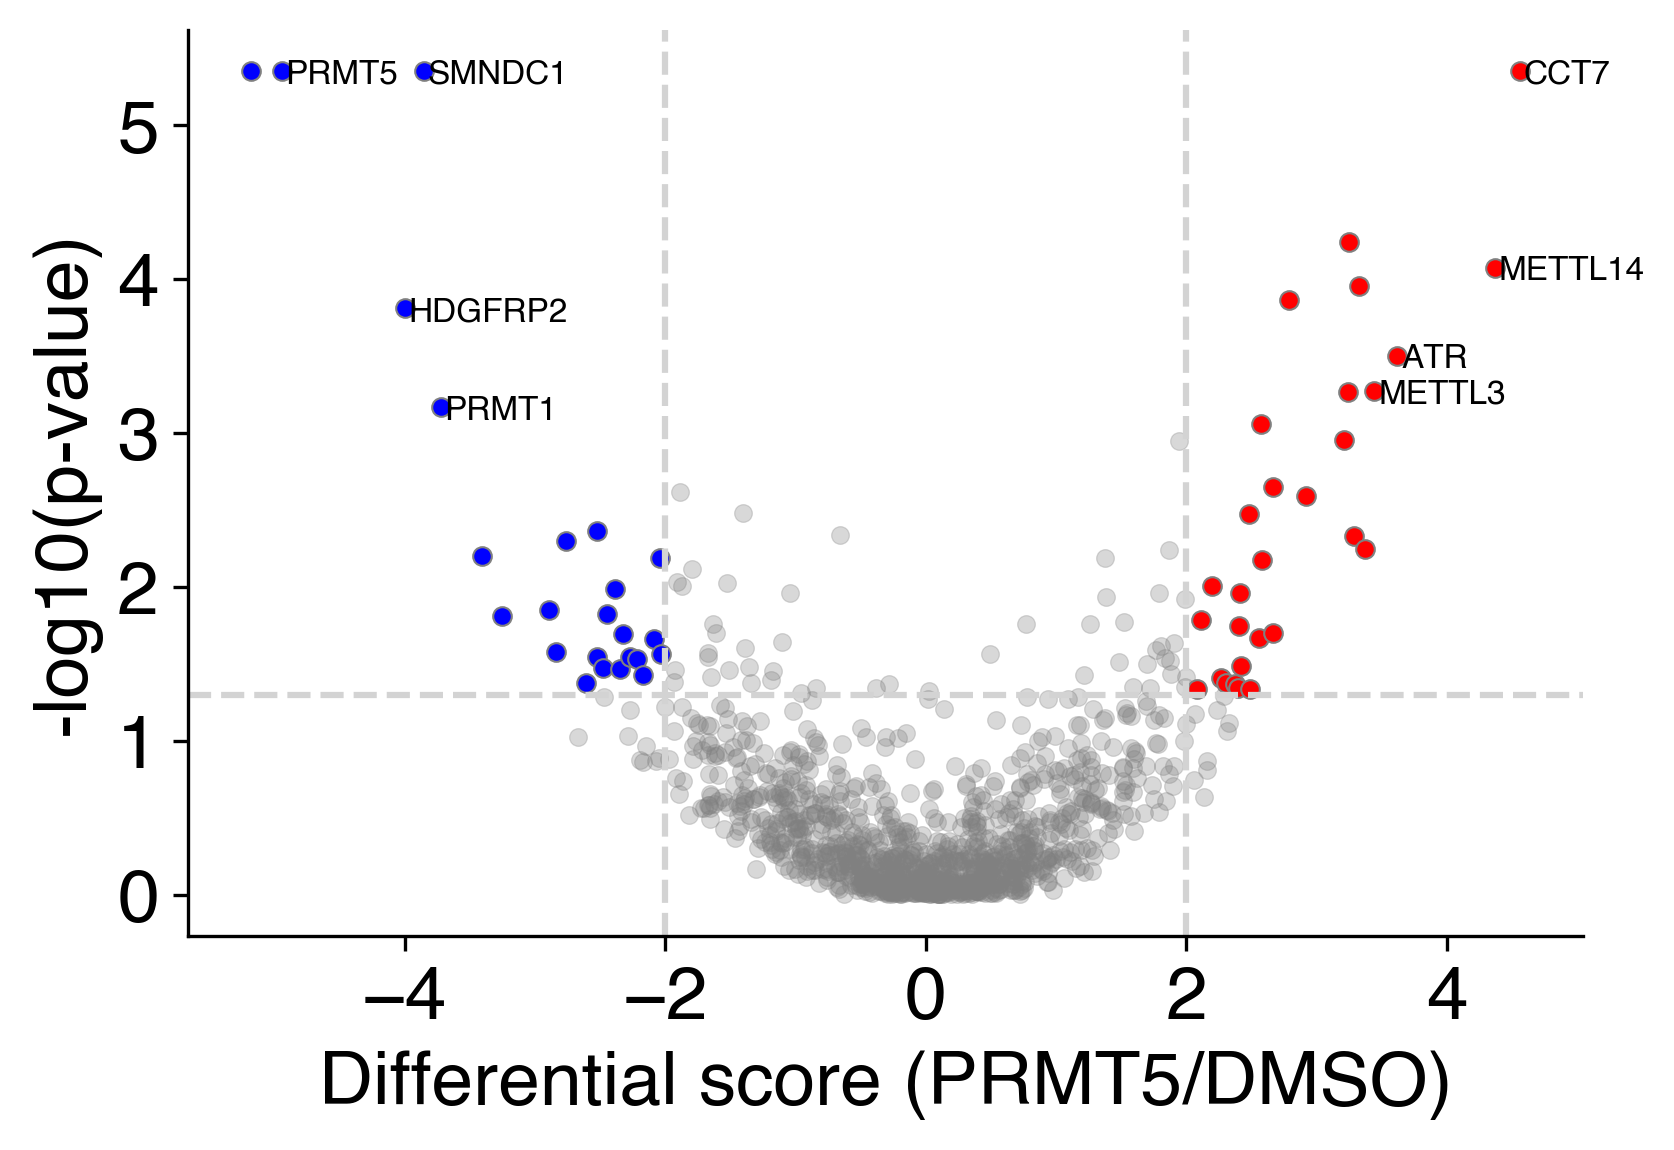

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6,4),dpi=300)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.rcParams["font.size"] = 18
plt.rcParams["font.family"] = "Helvetica"


plt.scatter(df_p['Z'],-np.log10(df_p['P(sgRNAs)']),s=18,color='grey',alpha=0.3,linewidths=0.3,edgecolors='grey')


label_ls1 = list(df_up['Gene'])

df_show1 = df_p.loc[label_ls1,:]
lfc_ls1 = list(df_show1['Z']); p_ls1 = list(-np.log10(df_show1['P(sgRNAs)']))

plt.scatter(lfc_ls1,p_ls1,s=20,color='red',linewidths=0.5,edgecolors='grey')

for i, txt in enumerate(label_ls1[-4:]):
    plt.annotate(txt, (lfc_ls1[-4:][i]+0.03, p_ls1[-4:][i]-0.08),fontsize=8)
    
label_ls2 = list(df_down['Gene'])

df_show2 = df_p.loc[label_ls2,:]
lfc_ls2 = list(df_show2['Z']); p_ls2 = list(-np.log10(df_show2['P(sgRNAs)']))

plt.scatter(lfc_ls2,p_ls2,s=20,color='blue',linewidths=0.5,edgecolors='grey')

for i, txt in enumerate(label_ls2[1:5]):
    plt.annotate(txt, (lfc_ls2[1:5][i]+0.03, p_ls2[1:5][i]-0.08),fontsize=8)

plt.axhline(y=1.3, linestyle='--', color='lightgray') 
plt.axvline(x=-2, linestyle='--', color='lightgray') 
plt.axvline(x=2, linestyle='--', color='lightgray') 

plt.xlabel('Differential score (PRMT5/DMSO)')
plt.ylabel('-log10(p-value)')


#plt.savefig('DifferentialEssential_volcanoplot.png',dpi=300,facecolor='white')
plt.show()

In [37]:
gene_up = list(df_down['Gene'])

print(gene_up)

go_up = go_analysis(gene_up)

go_up

['PPP4C', 'PRMT5', 'HDGFRP2', 'SMNDC1', 'PRMT1', 'WDR77', 'SRSF3', 'USP37', 'MBTD1', 'H2BFWT', 'INO80B', 'UBE2A', 'PRPF31', 'HUWE1', 'INO80', 'ERCC6', 'DICER1', 'GSE1', 'IDH1', 'POLR2I', 'SUZ12', 'ACTR3B', 'KAT7', 'ELL3']

Runing BP Ontology Analysis: current study set of 22 IDs.
 91%     20 of     22 study items found in association
100%     22 of     22 study items found in population(20641)
Calculating 12,396 uncorrected p-values using fisher_scipy_stats
  12,396 terms are associated with 17,018 of 20,641 population items
     211 terms are associated with     20 of     22 study items
  METHOD fdr_bh:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): statsmodels fdr_bh
      11 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 22 IDs.
 95%     21 of     22 study items found in association
100%     22 of     22 study items found

NameError: name 'GO_items' is not defined

In [47]:
gene_down = list(df_down['Gene'])

go_down = go_analysis(gene_down)

go_down


Runing BP Ontology Analysis: current study set of 22 IDs.
 91%     20 of     22 study items found in association
100%     22 of     22 study items found in population(20639)
Calculating 12,426 uncorrected p-values using fisher_scipy_stats
  12,426 terms are associated with 16,798 of 20,639 population items
     210 terms are associated with     20 of     22 study items
  METHOD fdr_bh:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): statsmodels fdr_bh
      12 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 22 IDs.
 95%     21 of     22 study items found in association
100%     22 of     22 study items found in population(20639)
Calculating 1,776 uncorrected p-values using fisher_scipy_stats
   1,776 terms are associated with 17,765 of 20,639 population items
      59 terms are associated with     21 of     22 study items
  M

,GO,term,class,p,p_corr,n_genes,n_study,n_go,study_genes,LogP
0,GO:0043985,histone H4-R3 methylation,biological_process,2.097969e-08,0.000261,3,22,6,"[WDR77, PRMT5, PRMT1]",7.678201
1,GO:0016574,histone ubiquitination,biological_process,8.793230e-08,0.000546,3,22,9,"[SUZ12, HUWE1, UBE2A]",7.055852
2,GO:0006275,regulation of DNA replication,biological_process,1.533703e-07,0.000635,4,22,46,"[INO80, INO80B, USP37, KAT7]",6.814259
3,GO:0032786,positive regulation of DNA-templated transcrip...,biological_process,5.833878e-07,0.001812,3,22,16,"[ERCC6, ELL3, KAT7]",6.234043
4,GO:0005654,nucleoplasm,cellular_component,3.865038e-09,0.000007,17,22,3849,"[HUWE1, KAT7, PRPF31, PRMT1, SMNDC1, WDR77, EL...",8.412846
5,GO:0034709,methylosome,cellular_component,2.985625e-07,0.000265,3,22,13,"[WDR77, PRMT5, PRMT1]",6.524965


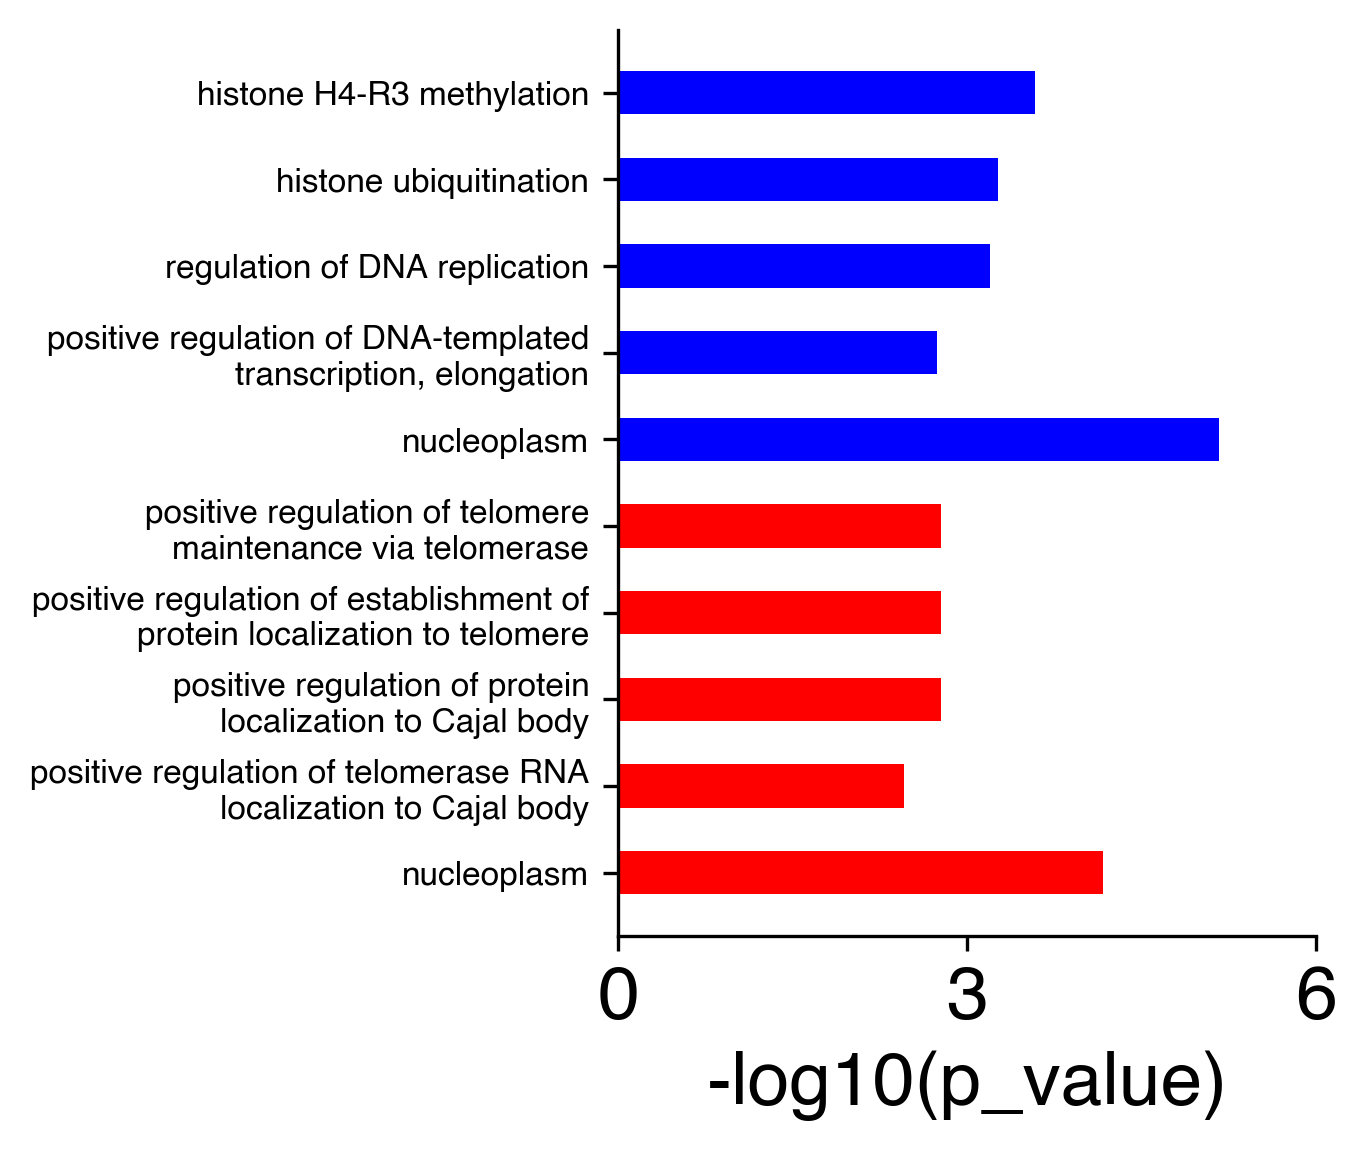

In [83]:
import matplotlib.pyplot as plt
import numpy as np
import textwrap

plt.figure(figsize=(3,4),dpi=300)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.rcParams["font.size"] = 10
plt.rcParams["font.family"] = "Helvetica"

up_labels = [s for s in go_up['term'][0:5]][::-1]
up_pvalues = [-np.log10(p) for p in go_up['p_corr'][0:5]][::-1]
up_ycor = [0.1*n for n in range(1,len(up_labels)+1)]

down_labels = [s for s in go_down['term'][0:5]][::-1]
down_pvalues = [-np.log10(p) for p in go_down['p_corr'][0:5]][::-1]

down_ycor = [0.1*n for n in range(len(down_labels)+1,len(down_labels)+len(up_labels)+1)]

#print(len(y_cor),len(labels),len(p_values))

plt.barh(up_ycor,up_pvalues,height=0.05,color='red')

plt.barh(down_ycor,down_pvalues,height=0.05, color='blue')

plt.yticks(up_ycor+down_ycor,[textwrap.fill(e,40) for e in up_labels+down_labels],fontsize=8)

#plt.yticks()
plt.xticks([0,3.0,6.0])
plt.xlabel('-log10(p_value)')

plt.savefig('PRMT5_GO_plot.pdf',dpi=300,bbox_inches='tight')

plt.show()

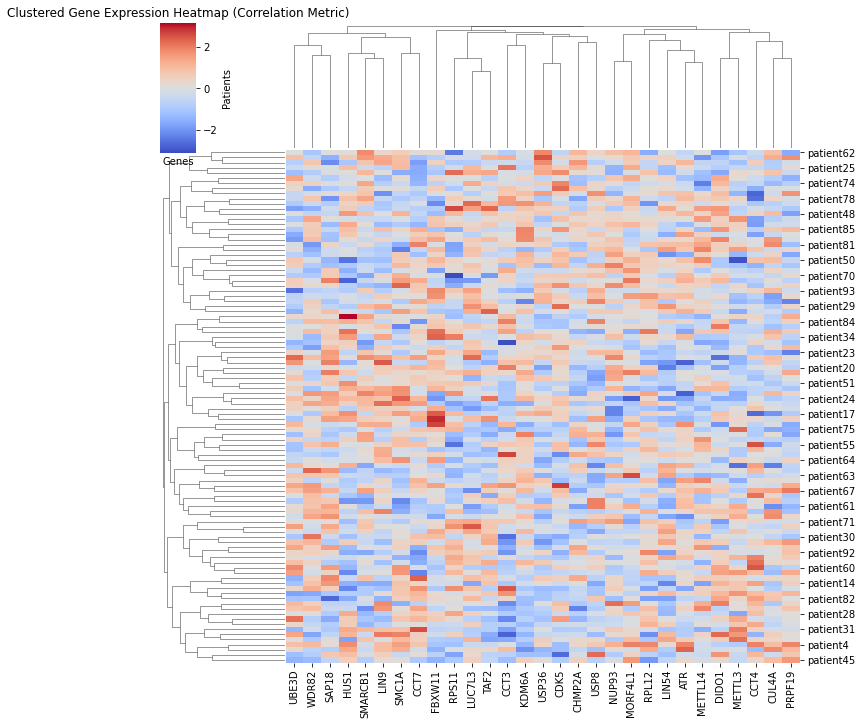

In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define gene list and patient IDs
genes = ['SMARCB1', 'FBXW11', 'WDR82', 'LUC7L3', 'NUP93', 'LIN54', 'CUL4A', 'CHMP2A', 'USP8', 'CCT3',
         'HUS1', 'SAP18', 'USP36', 'PRPF19', 'KDM6A', 'CDK5', 'LIN9', 'RPS11', 'MORF4L1', 'TAF2',
         'DIDO1', 'CCT4', 'SMC1A', 'RPL12', 'UBE3D', 'METTL3', 'ATR', 'METTL14', 'CCT7']

patients = ['patient' + str(i) for i in range(1, 101)]  # Generate patient IDs

# Generate random gene expression data
np.random.seed(0)
expression_data = pd.DataFrame(np.random.randn(len(patients), len(genes)), columns=genes, index=patients)

# Perform clustering using correlation metric and plot the heatmap
clustered_heatmap = sns.clustermap(expression_data, cmap='coolwarm', cbar=True, metric='correlation')
plt.title('Clustered Gene Expression Heatmap (Correlation Metric)')
plt.xlabel('Genes')
plt.ylabel('Patients')
plt.show()



In [88]:
expression_data

,SMARCB1,FBXW11,WDR82,LUC7L3,NUP93,LIN54,CUL4A,CHMP2A,USP8,CCT3,HUS1,SAP18
patient1,2.882026,2.200079,2.489369,3.120447,-1.299327,-1.557948,-0.616668,-0.821854,-1.294414,-1.607098,-2.028735,-2.195609
patient2,2.933779,1.511361,2.475044,1.924321,-1.884269,-0.822259,-0.592740,-0.970537,-1.529541,-1.797398,-1.750974,-2.013096
patient3,1.948391,2.205299,2.072022,2.727137,-1.092527,-1.403824,-1.723267,-0.599851,-2.844115,-2.056233,-2.266245,-1.677472
patient4,2.380519,2.060838,2.221932,2.166837,-1.154557,-1.116733,-0.133639,-0.657749,-1.494079,-2.328976,-1.765807,-1.132061
patient5,2.747040,1.897421,2.156534,1.572952,-0.814587,-0.928969,-0.240003,-0.140205,-2.333856,-1.159039,-2.426293,-1.988520
...,...,...,...,...,...,...,...,...,...,...,...,...
patient96,1.150947,2.193640,0.872218,1.488747,-0.255322,-0.739348,-0.694036,-1.670748,-1.047468,-2.007389,-2.150239,-2.177514
patient97,2.019315,1.171642,1.507245,1.264082,-0.761551,-0.925775,-0.735477,-0.788686,-2.946181,-2.088907,-1.874501,-1.472621
patient98,2.824067,2.082114,2.283645,1.888662,-1.679890,-1.020700,-1.378935,-1.025042,-1.519976,-2.208250,-2.138411,-1.438047
patient99,1.823284,1.191763,1.854081,1.619254,-1.448700,-0.343765,-1.429486,-1.449471,-2.086732,-2.255015,-1.303741,-1.481207


12


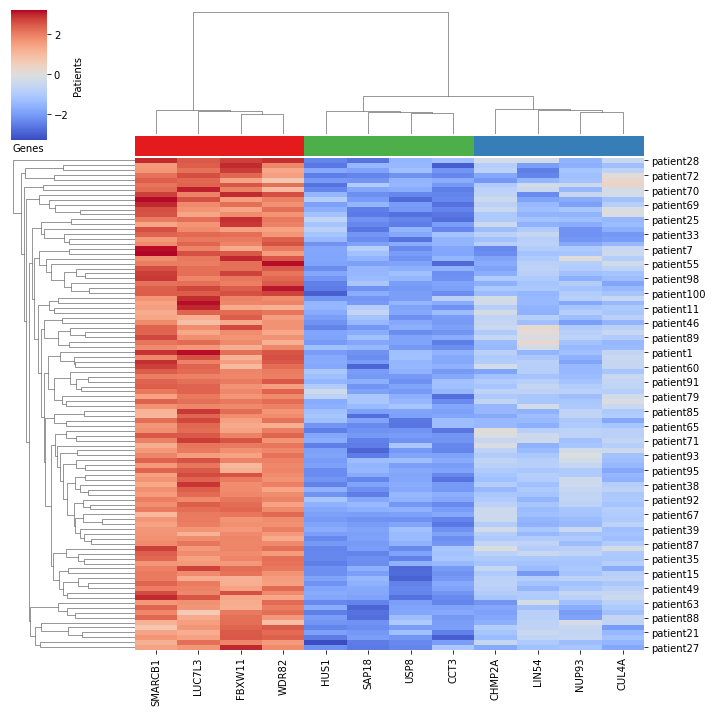

In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define gene list and patient IDs
genes = ['SMARCB1', 'FBXW11', 'WDR82', 'LUC7L3', 'NUP93', 'LIN54', 'CUL4A', 'CHMP2A', 'USP8', 'CCT3',
         'HUS1', 'SAP18', 'USP36', 'PRPF19', 'KDM6A', 'CDK5', 'LIN9', 'RPS11', 'MORF4L1', 'TAF2',
         'DIDO1', 'CCT4', 'SMC1A', 'RPL12', 'UBE3D', 'METTL3', 'ATR', 'METTL14', 'CCT7']

patients = ['patient' + str(i) for i in range(1, 101)]  # Generate patient IDs

# Generate random gene expression data with three distinct clusters
np.random.seed(0)

# Cluster 1
cluster1_genes = ['SMARCB1', 'FBXW11', 'WDR82', 'LUC7L3']
cluster1_data = np.random.normal(loc=2, scale=0.5, size=(len(patients), len(cluster1_genes)))

# Cluster 2
cluster2_genes = ['NUP93', 'LIN54', 'CUL4A', 'CHMP2A']
cluster2_data = np.random.normal(loc=-1, scale=0.5, size=(len(patients), len(cluster2_genes)))

# Cluster 3
cluster3_genes = ['USP8', 'CCT3', 'HUS1', 'SAP18']
cluster3_data = np.random.normal(loc=-2, scale=0.5, size=(len(patients), len(cluster3_genes)))

# Define color palette for subtypes
color_palette = sns.color_palette("Set1", n_colors=3)

colors=[color_palette[0]]*len(cluster1_genes) + [color_palette[1]]*len(cluster2_genes) + [color_palette[2]]*len(cluster3_genes)

print(len(colors))
# Perform clustering using correlation metric and plot the heatmap
clustered_heatmap = sns.clustermap(expression_data, cmap='coolwarm', metric='euclidean',
                                   col_colors=colors)

# Add legend for subtypes
# subtype_labels = ['Subtype 1', 'Subtype 2', 'Subtype 3']
# legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8)
#                    for label, color in zip(subtype_labels, color_palette)]
# plt.legend(handles=legend_elements, loc='upper left')

#plt.title('Clustered Gene Expression Heatmap (Correlation Metric)')
plt.xlabel('Genes')
plt.ylabel('Patients')
plt.show()